In [1]:
using LinearAlgebra
using GPFlux
using Plots; pyplot();
using Random; Random.seed!(4);
using Flux
using Zygote
using Optim
using DelimitedFiles
using Statistics
using Test

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


In [2]:
# read CO2 data
data = readdlm("CO2_data.csv", ',')
year = data[:,1]; co2 = data[:,2];
# Split the data into training and testing data
xtrain = year[year.<2004]; ytrain = co2[year.<2004];
xtest = year[year.>=2004]; ytest = co2[year.>=2004];
Xtrain = reshape(xtrain, 1, :);
Xtest = reshape(xtest, 1, :);

In [ ]:
# data preprocessing
## standardize X and y
# xtrain_mean = mean(xtrain)
# ytrain_mean = mean(ytrain)
# xtrain_std = std(xtrain)
# ytrain_std = std(ytrain)
# normalize_xtrain = @. (xtrain-xtrain_mean)/xtrain_std
# normalize_ytrain = @. (ytrain-ytrain_mean)/ytrain_std

# normalize_xtest = @. (xtest-xtrain_mean)/xtrain_std
# normalize_ytest = @. (ytest-ytrain_mean)/ytrain_std

# # input data
# Xtrain = reshape(normalize_xtrain, 1, length(normalize_xtrain));
# Xtest = reshape(normalize_xtest, 1, length(normalize_xtest));

In [17]:
# kernel parameter initialization
function median_distance_local(x)
    n = length(x)
    dist = []
    for i in 1:n
        for j in (i+1):n
            push!(dist, abs(x[j]-x[i]))
        end
    end
    median(dist)
end

l = median_distance_local(xtrain)

13.416666666666742

In [18]:
# construct kernels
iso_lin_kernel = IsoLinearKernel([0.0])
iso_per_kernel = IsoPeriodKernel([log(l)], [log(l)], [0.0])
iso_rbf_kernel = IsoGaussKernel([log(l)], [0.0])

# sum product network
linear1 = Linear(3, 1)

# NKN
nkn = NeuralKernelNetwork(Primitive(iso_lin_kernel, iso_per_kernel, iso_rbf_kernel), linear1 |> f64)

NeuralKernelNetwork{Tuple{Primitive{Tuple{IsoLinearKernel{Float64,Array{Float64,1}},IsoPeriodKernel{Float64,Array{Float64,1}},IsoGaussKernel{Float64,Array{Float64,1}}}},Linear{Array{Float64,2},Array{Float64,1}}}}((Primitive{Tuple{IsoLinearKernel{Float64,Array{Float64,1}},IsoPeriodKernel{Float64,Array{Float64,1}},IsoGaussKernel{Float64,Array{Float64,1}}}}((IsoLinearKernel{Float64,Array{Float64,1}}([0.0]), IsoPeriodKernel{Float64,Array{Float64,1}}([2.5964977151964685], [2.5964977151964685], [0.0]), IsoGaussKernel{Float64,Array{Float64,1}}([2.5964977151964685], [0.0]))), Linear{Array{Float64,2},Array{Float64,1}}([-0.953677773475647 0.5081663131713867 1.1278239488601685], [0.0])))

In [19]:
# build gp model
zero_mean = ConstantMean()
lnoise = [0.5*log(0.1)]
gp = GaussProcess(zero_mean, nkn, lnoise)
ps = params(gp)
negloglik(gp, Xtrain, ytrain)

12649.398212166532

In [14]:
function calc_g!(G, θ)
    dispatch!(gp, θ)
    ps = params(gp)
    gs = gradient(()->negloglik(gp, Xtrain, ytrain, λ=0.1), ps)

    j = 1
    for p in ps
        lp = length(p)
        G[j:j+lp-1] .= vec(gs.grads[p])
        j += lp
    end
    G
end

function loss_fn(θ)
    dispatch!(gp, θ)
    negloglik(gp, Xtrain, ytrain, λ=0.1)
end

θ = flatten_params(ps)
@show loss_fn(θ)
@show calc_g!(zeros(length(θ)), θ)
@test loss_fn(θ) ≈ negloglik(gp, Xtrain, ytrain, λ=0.1)

loss_fn(θ) = 8168.786645009569
calc_g!(zeros(length(θ)), θ) = [1.6605581265988256, -0.9280937232592805, 183.26278236687276, 18.206178739938988, -21.018318818758416, 450.281802136068, -3500.417143156852, 0.36685830522379814, -5.828073578731588, -1450.4803973639912, -0.6891842204786371, -6048.116282535703]


Test Passed

In [20]:
# minimize negative loglik

using Flux.Optimise: update!

optimizer = ADAM(0.001)
loss = []
for i in 1:2000
    ll = negloglik(gp, Xtrain, ytrain)
    push!(loss, ll)
    if i==1 || i%200 == 0
        @info "step=$i, loss=$ll"
    end
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
    for p in ps
        update!(optimizer, p, gs[p])
    end
end

┌ Info: step=1, loss=12649.398212166532
└ @ Main In[20]:11
┌ Info: step=200, loss=8707.23528919684
└ @ Main In[20]:11
┌ Info: step=400, loss=6444.987807543154
└ @ Main In[20]:11
┌ Info: step=600, loss=5019.656367520052
└ @ Main In[20]:11
┌ Info: step=800, loss=4062.548744573977
└ @ Main In[20]:11
┌ Info: step=1000, loss=3391.876622476088
└ @ Main In[20]:11
┌ Info: step=1200, loss=2906.522601991356
└ @ Main In[20]:11
┌ Info: step=1400, loss=2545.0887026252326
└ @ Main In[20]:11
┌ Info: step=1600, loss=2269.9296768027916
└ @ Main In[20]:11
┌ Info: step=1800, loss=2056.847868279769
└ @ Main In[20]:11
┌ Info: step=2000, loss=1889.608445380274
└ @ Main In[20]:11


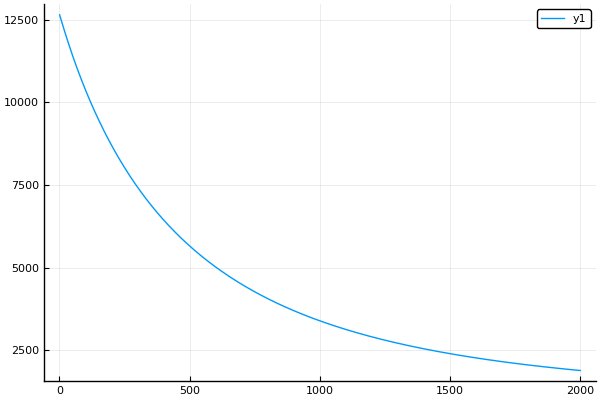

In [21]:
plot(loss)

In [22]:
pred_y, pred_σ2 = predict(gp, Xtest, Xtrain, ytrain)
pred_σ = sqrt.(pred_σ2);

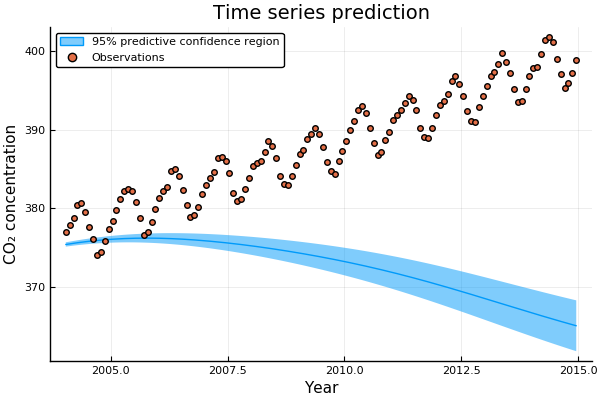

In [23]:
plot(xtest, pred_y, ribbon=pred_σ, title="Time series prediction",label="95% predictive confidence region")
scatter!(xtest, ytest, label="Observations")
plot!(xaxis=("Year"), yaxis=("CO₂ concentration"))